# Evaluation of Graph Neural Network segment classifier

In [1]:
%pwd

'/global/u2/d/danieltm/ExaTrkX/exatrkx-work/gnn_pytorch/notebooks'

In [3]:
# System imports
import os
import sys
import pprint

# External imports
import matplotlib.pyplot as plt
import numpy as np

# Limit CPU usage on Jupyter
os.environ['OMP_NUM_THREADS'] = '4'

# Pick up local packages
sys.path.append('..')

# Local imports
from trainers import get_trainer
from data_utils import (load_config_file, load_config_dir, load_summaries,
                      plot_train_history, get_test_data_loader,
                      compute_metrics, plot_metrics, draw_sample_xy)

In [4]:
%matplotlib inline

## Load training results

Specify which results to load either by config file or training output directory.

In [5]:
# Load by directory (preferred)
result_base = os.path.expandvars('$SCRATCH/ExaTrkX/processed_sparse/results/')

In [6]:
ls $result_base

high_000/  high_003/            high_augmented_002/  small_001/  small_004/
high_001/  high_augmented_000/  high_augmented_003/  small_002/  triplets/
high_002/  high_augmented_001/  small_000/           small_003/


In [7]:
result_name = 'high_003'
result_dir = os.path.join(result_base, result_name)

config = load_config_dir(result_dir)
print('Configuration:')
pprint.pprint(config)

summaries = load_summaries(config)
print('\nTraining summaries:')
summaries

Configuration:
{'data': {'batch_size': 4,
          'input_dir': '${SCRATCH}/ExaTrkX/processed_sparse/adjacent/doublets/high_fullsplit/',
          'n_train': 56000,
          'n_valid': 1600,
          'n_workers': 4,
          'name': 'hitgraphs_sparse',
          'real_weight': 2.5},
 'model': {'hidden_activation': 'Tanh',
           'hidden_dim': 64,
           'input_dim': 3,
           'layer_norm': True,
           'loss_func': 'binary_cross_entropy_with_logits',
           'n_graph_iters': 8,
           'name': 'resgnn'},
 'n_ranks': 8,
 'optimizer': {'learning_rate': 0.001, 'name': 'Adam', 'weight_decay': 0.0001},
 'output_dir': '/global/cscratch1/sd/danieltm/ExaTrkX/processed_sparse/results/high_003',
 'trainer': {'name': 'gnn_sparse'},
 'training': {'n_total_epochs': 90}}

Training summaries:


,lr,train_loss,l1,l2,epoch,train_time,valid_loss,valid_acc,valid_time
0,0.00100,0.480320,2724.761733,25.529860,0,368.761703,0.213951,0.908253,5.329962
1,0.00100,0.287234,2756.561342,25.511140,1,365.699270,0.166751,0.930555,4.984706
2,0.00100,0.255982,2792.886014,25.511949,2,365.568742,0.184168,0.922824,4.849235
3,0.00100,0.227256,2817.883548,25.491329,3,365.997961,0.131679,0.945866,4.852307
4,0.00100,0.267749,2857.947180,25.503524,4,365.732243,0.139397,0.943319,5.220142
5,0.00100,0.208958,2881.313417,25.480691,5,365.553983,0.120133,0.950475,4.833835
6,0.00100,0.213459,2913.146642,25.503262,6,365.107543,0.124390,0.949635,4.888471
7,0.00100,0.210994,2945.498143,25.523710,7,366.041092,0.119422,0.951258,4.848629
8,0.00100,0.198235,2971.334172,25.539901,8,365.688171,0.106836,0.956552,4.818961
9,0.00100,0.202822,2992.512530,25.517580,9,365.631917,0.109237,0.955272,4.776529


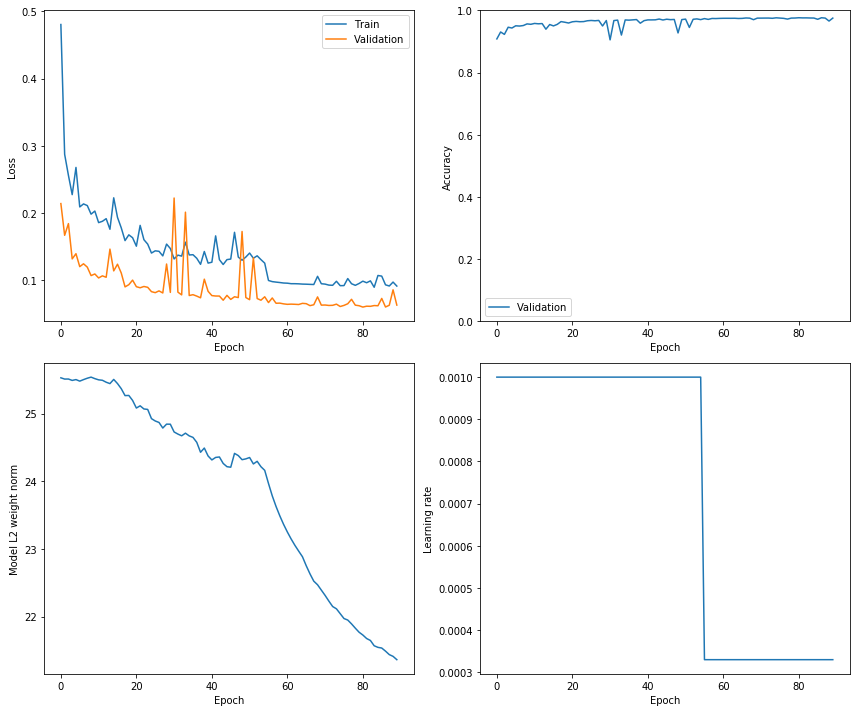

In [8]:
plot_train_history(summaries)

Text(0, 0.5, 'Learning rate')

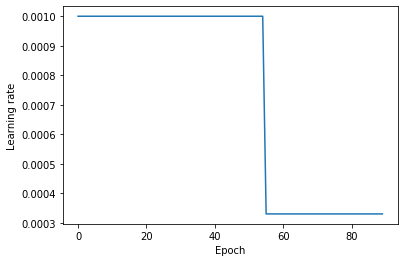

In [9]:
# Plot the learning rate
plt.figure()
plt.plot(summaries.lr)
plt.xlabel('Epoch')
plt.ylabel('Learning rate')

## Load the trained model

In [10]:
# Find the best epoch
best_idx = summaries.valid_loss.idxmin()
summaries.loc[[best_idx]]

,lr,train_loss,l1,l2,epoch,train_time,valid_loss,valid_acc,valid_time
80,0.00033,0.098534,2659.30021,21.727648,80,397.729241,0.059998,0.97637,5.362723


In [11]:
# Build the trainer and load best checkpoint
trainer = get_trainer(output_dir=config['output_dir'], gpu=0, **config['trainer'])
trainer.build_model(optimizer_config=config['optimizer'], **config['model'])

best_epoch = summaries.epoch.loc[best_idx]
trainer.load_checkpoint(checkpoint_id=best_epoch)

print(trainer.model)
print('Parameters:', sum(p.numel() for p in trainer.model.parameters()))

GNNSegmentClassifier(
  (input_network): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): Tanh()
  )
  (edge_network): EdgeNetwork(
    (network): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (2): Tanh()
      (3): Linear(in_features=64, out_features=64, bias=True)
      (4): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (5): Tanh()
      (6): Linear(in_features=64, out_features=64, bias=True)
      (7): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (8): Tanh()
      (9): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (node_network): NodeNetwork(
    (network): Sequential(
      (0): Linear(in_features=192, out_features=64, bias=True)
      (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (2): Tanh()
      (3): Linear(in_features=64, out_fea

## Evaluate the model on the test dataset

In [21]:
# Load the test dataset
n_test = 80
test_loader, _ = get_test_data_loader(config, n_test=n_test)

In [22]:
%%time
# Apply the model
test_preds, test_targets = trainer.device_predict(test_loader)

CPU times: user 5.83 s, sys: 6.82 s, total: 12.7 s
Wall time: 7.04 s


In [37]:
threshold = 0.1
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)

Test set results with threshold of 0.1
Accuracy:  0.9370
Precision: 0.7383
Recall:    0.9912


In [39]:
sum(test_preds[0].numpy() > 0.1)

7064

In [40]:
sum(test_targets[0].numpy() > 0)

5260

In [15]:
threshold = 0.8
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)

Test set results with threshold of 0.8
Accuracy:  0.9779
Precision: 0.9696
Recall:    0.9086


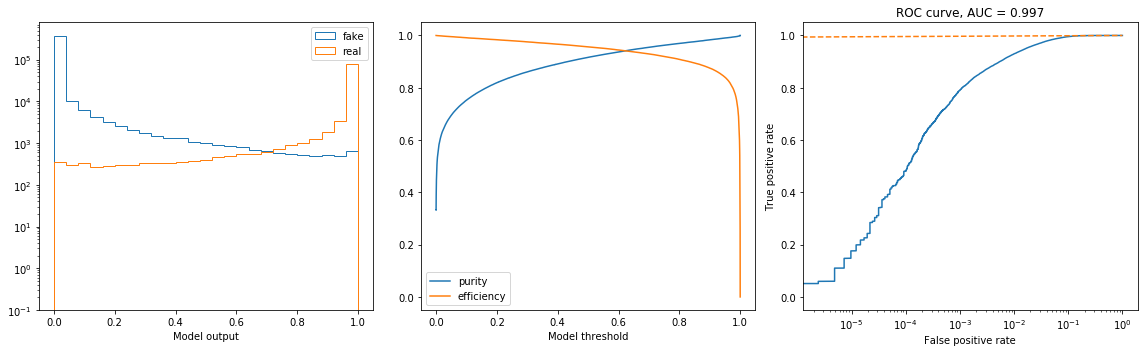

In [16]:
plot_metrics(test_preds, test_targets, test_metrics, "log")

## Visualize predictions

In [16]:
n_phi_sections = 8
feature_scale = np.array([1000., np.pi / n_phi_sections, 1000.])

In [17]:
i = 0

g = test_loader.dataset[i]
e = g.edge_index.numpy()
x = g.x.numpy() * feature_scale
y = g.y.numpy()
o = test_preds[i].numpy()

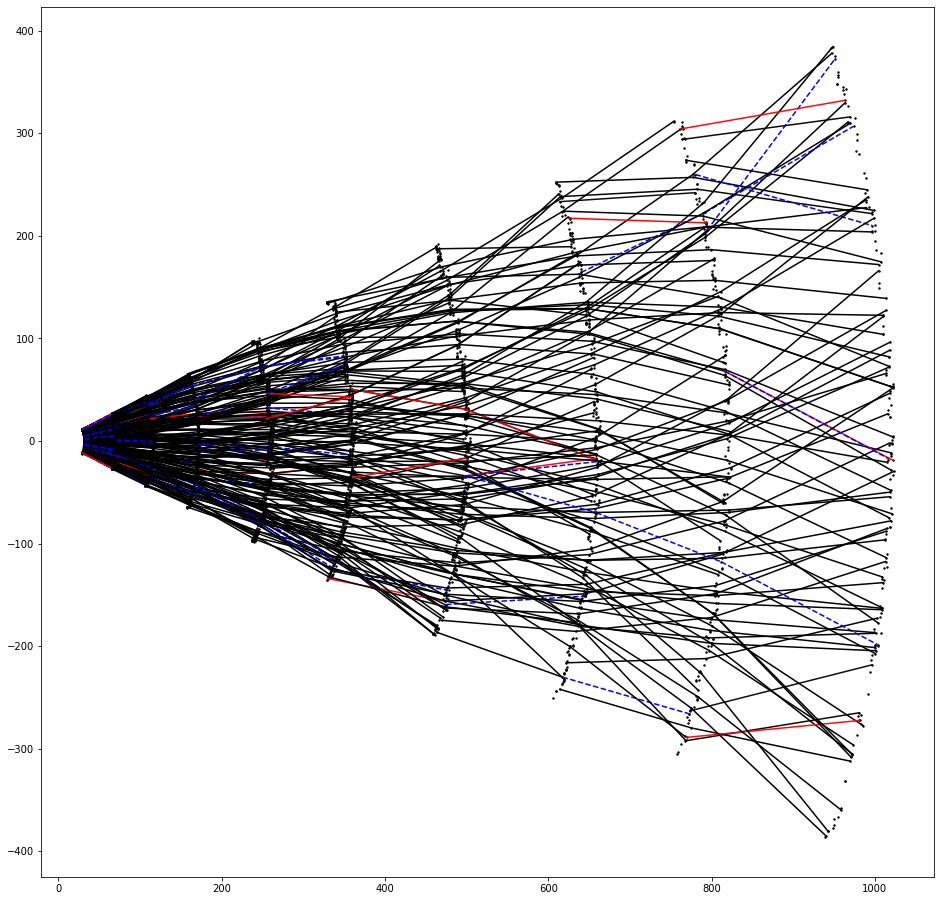

In [18]:
draw_sample_xy(x, e, o, y, cut=0.9);